# cGAN Tutorial
Implemented in PyTorch

Source: https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/

In [28]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import datetime
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from matplotlib import pyplot
from matplotlib import gridspec
import tensorflow_datasets as tfds
import os
import shutil
from PIL import Image

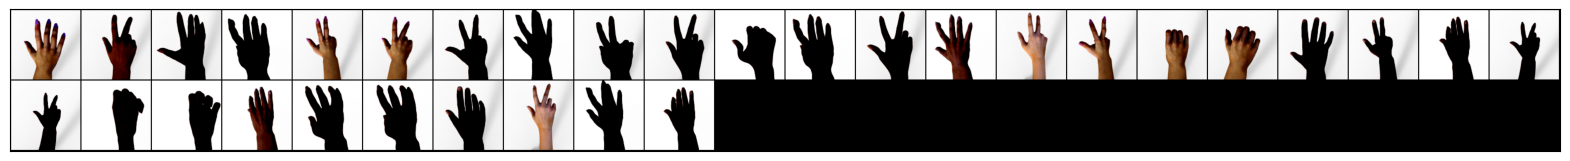

In [29]:
# Data loading and preprocessing

torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128

# Load the Rock-Paper-Scissors dataset
dataset, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=True)

# Split the dataset into training and testing sets
train_dataset, test_dataset = dataset['train'], dataset['test']

# Define a function to convert the TensorFlow dataset to PyTorch tensors
def tfds_to_pytorch(dataset):
    for image, label in tfds.as_numpy(dataset):
        # Convert image to PIL Image
        image = transforms.ToPILImage()(image)
        # Apply transformations
        image = transform(image)
        yield image, torch.tensor(label)

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Convert the datasets to PyTorch tensors
train_dataset = tfds_to_pytorch(train_dataset)
test_dataset = tfds_to_pytorch(test_dataset)

# Wrap the dataset with DataLoader
train_loader = torch.utils.data.DataLoader(list(train_dataset), batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(test_dataset), batch_size=32, shuffle=False)

def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

show_batch(train_loader)

image_shape = (3, 128, 128)
image_dim = int(np.prod(image_shape))
latent_dim = 100

n_classes = 3
embedding_dim = 100

In [30]:
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

## Generator

In [31]:
# Generator

# Notes:
# - Very similar architecture to regular GAN generator

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
     
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))
        
    
        self.latent = nn.Sequential(nn.Linear(latent_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))
           

        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*1, 3, 4, 2, 1, bias=False),
                      nn.Tanh())

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(3, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_si

In [32]:
a = torch.ones(100)
b = torch.ones(1)
b = b.long()
a = a.to(device)
b = b.to(device)

## Discriminator

In [33]:
# Discriminator

# Notes:
# - Works with images and labels

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
    
        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 3*128*128))
             
        self.model = nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1),
                      nn.Sigmoid()
                     )

    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 128, 128)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (label_condition_disc): Sequential(
    (0): Embedding(3, 100)
    (1): Linear(in_features=100, out_features=49152, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)


In [34]:
a = torch.ones(2,3,128,128)
b = torch.ones(2,1)
b = b.long()
a = a.to(device)
b = b.to(device)

c = discriminator((a,b))
c.size()

torch.Size([2, 1])

## Loss function

In [35]:
adversarial_loss = nn.BCELoss() 

adversarial_loss = nn.BCELoss() 

def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    #print(gen_loss)
    return gen_loss

def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

learning_rate = 0.0002 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [36]:
# Prepare images and training weights folders before training loop

def clear_folder(folder_path):
    """Remove all files and subfolders in the given folder."""
    if os.path.exists(folder_path):
        # Remove all files and subdirectories
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        print(f"Cleared contents of {folder_path}")
    else:
        print(f"Folder {folder_path} does not exist")

# Paths to folders
image_folder = 'C:\\Users\\johna\\Downloads\\research\\torch\\images'
weights_folder = 'C:\\Users\\johna\\Downloads\\research\\torch\\training_weights'

# Clear folders before training loop
clear_folder(image_folder)
clear_folder(weights_folder)

Folder C:\Users\johna\Downloads\research\torch\images does not exist
Folder C:\Users\johna\Downloads\research\torch\training_weights does not exist


## Training loop

In [37]:
# Training

# Notes:
# - Similar to regular GAN, additional lines for labels

num_epochs = 100
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs+1): 

    D_loss_list, G_loss_list = [], []
   
    for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).long()

      
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
      
        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
        # print(discriminator(real_images))
        #D_real_loss.backward()
    
        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
        noise_vector = noise_vector.to(device)
        
       
        generated_image = generator((noise_vector, labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)

    
        # train with fake
        #D_fake_loss.backward()
      
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
      
        D_total_loss.backward()
        D_optimizer.step()

        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()


    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
    save_image(generated_image.data[:50], 'cGAN/images/sample_%d'%epoch + '.png', nrow=5, normalize=True)
     
    torch.save(generator.state_dict(), 'cGAN/training_weights/generator_epoch_%d.pth' % (epoch))
    torch.save(discriminator.state_dict(), 'cGAN/training_weights/discriminator_epoch_%d.pth' % (epoch))

    label_path = os.path.join('cGAN/labels', f'labels_{epoch}.pt')
    torch.save(labels.data[:50], label_path)

generator.load_state_dict(torch.load('cGAN/training_weights/generator_epoch_1.pth'), strict=False)
generator.eval()

Epoch: [1/100]: D_loss: 0.276, G_loss: 2.354
Epoch: [2/100]: D_loss: 0.360, G_loss: 2.218
Epoch: [3/100]: D_loss: 0.462, G_loss: 1.849
Epoch: [4/100]: D_loss: 0.472, G_loss: 1.747
Epoch: [5/100]: D_loss: 0.448, G_loss: 1.832
Epoch: [6/100]: D_loss: 0.401, G_loss: 1.943
Epoch: [7/100]: D_loss: 0.364, G_loss: 2.258
Epoch: [8/100]: D_loss: 0.371, G_loss: 2.184
Epoch: [9/100]: D_loss: 0.404, G_loss: 1.997
Epoch: [10/100]: D_loss: 0.419, G_loss: 1.932
Epoch: [11/100]: D_loss: 0.427, G_loss: 1.890
Epoch: [12/100]: D_loss: 0.398, G_loss: 1.898
Epoch: [13/100]: D_loss: 0.409, G_loss: 1.980
Epoch: [14/100]: D_loss: 0.398, G_loss: 2.012
Epoch: [15/100]: D_loss: 0.379, G_loss: 2.095
Epoch: [16/100]: D_loss: 0.369, G_loss: 2.143
Epoch: [17/100]: D_loss: 0.363, G_loss: 2.201
Epoch: [18/100]: D_loss: 0.444, G_loss: 2.255
Epoch: [19/100]: D_loss: 0.320, G_loss: 2.266
Epoch: [20/100]: D_loss: 0.313, G_loss: 2.335
Epoch: [21/100]: D_loss: 0.344, G_loss: 2.510
Epoch: [22/100]: D_loss: 0.320, G_loss: 2.4

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(3, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_si

## Visualization

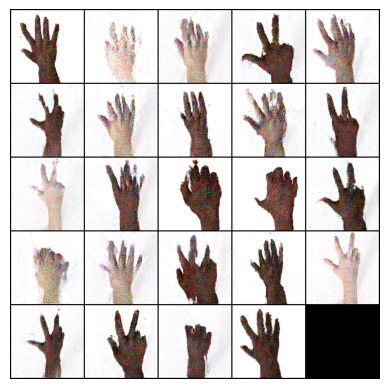

Labels: tensor([[1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 0, 0, 2, 0, 1, 2, 1, 2, 2, 2, 0, 1]])

Labels correspond to: 
 0: rock
 1: paper
 2: scissors


In [38]:
# Folder containing the generated images
images_folder = r"C:\Users\johna\Downloads\research\cGAN\images"
labels_folder = r"C:\Users\johna\Downloads\research\cGAN\labels"

# Construct the filename for the specified epoch
image_filename = f"sample_{epoch}.png"
image_path = os.path.join(images_folder, image_filename)

label_path = os.path.join(labels_folder, f'labels_{epoch}.pt')
labels = torch.load(label_path)

# Load the image
image_path = os.path.join(images_folder, f'sample_{epoch}.png')
image = Image.open(image_path)

# Load the corresponding labels
label_path = os.path.join(labels_folder, f'labels_{epoch}.pt')
labels = torch.load(label_path)
labels = labels.cpu()
labels = labels.reshape(1, -1)

# Display the image and print the corresponding labels
plt.imshow(image)
plt.axis('off')
plt.show()
print(f'Labels: {labels}')
print('\nLabels correspond to: \n 0: rock\n 1: paper\n 2: scissors')

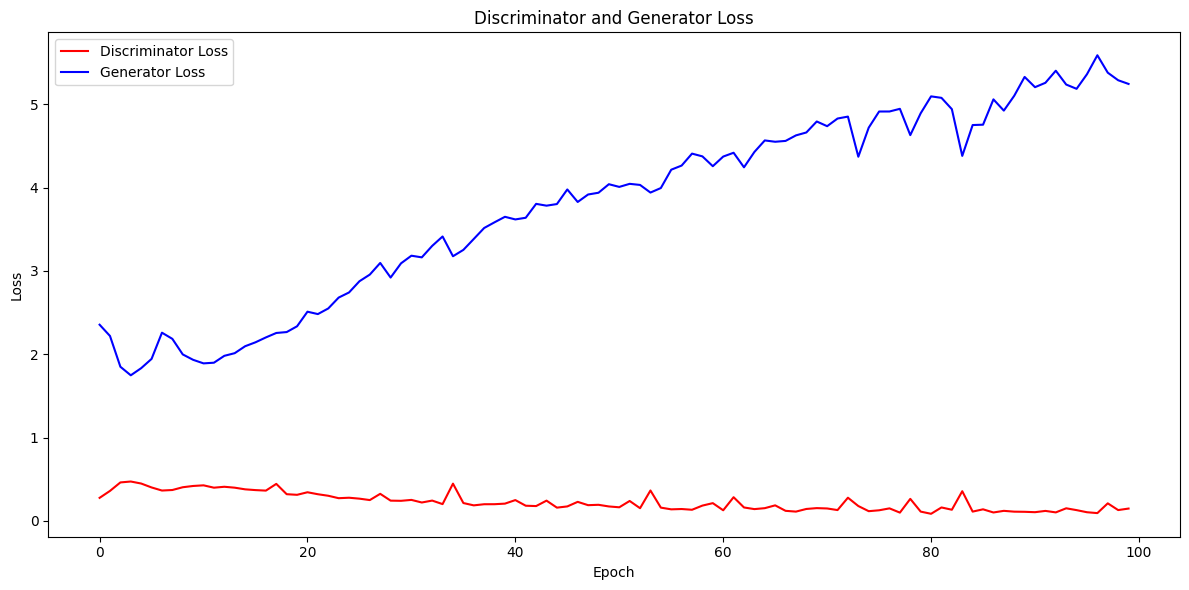

In [41]:
# Loss plots
plt.figure(figsize=(12, 6))
plt.title("Discriminator and Generator Loss")

# Plot Discriminator Loss
plt.plot(D_loss_plot, label='Discriminator Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Generator Loss
plt.plot(G_loss_plot, label='Generator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()